In [18]:
%load_ext autoreload
%autoreload 2
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure # и другие метрики
from sklearn.cluster import KMeans, AgglomerativeClustering # а также другие алгоритмы

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [20]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [21]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x = X[:, 0], y = X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

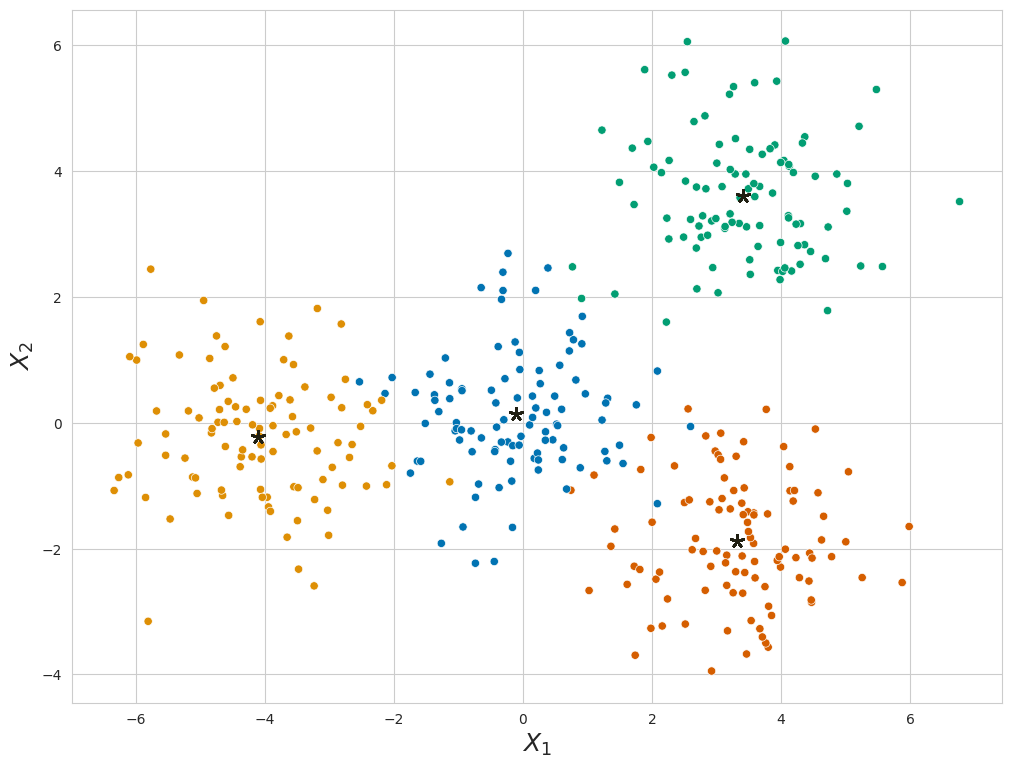

In [22]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [23]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=0)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        """
        YOUR CODE IS HERE
        """
        dists = []
        for centroid in self.centroids:
            dists.append(self._calculate_distance(X, centroid))
        
        cluster_labels = np.argmin(dists, axis=0)
        
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        
        """
        YOUR CODE IS HERE
        """
        dist = np.sqrt(np.sum(np.square(X - centroid), axis=1))
        
        return dist
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

> Сравним 2 способа инициализации центроидов и посмотрим, удается ли добиться сходимости при небольшом количестве итераций (возьмем 5).

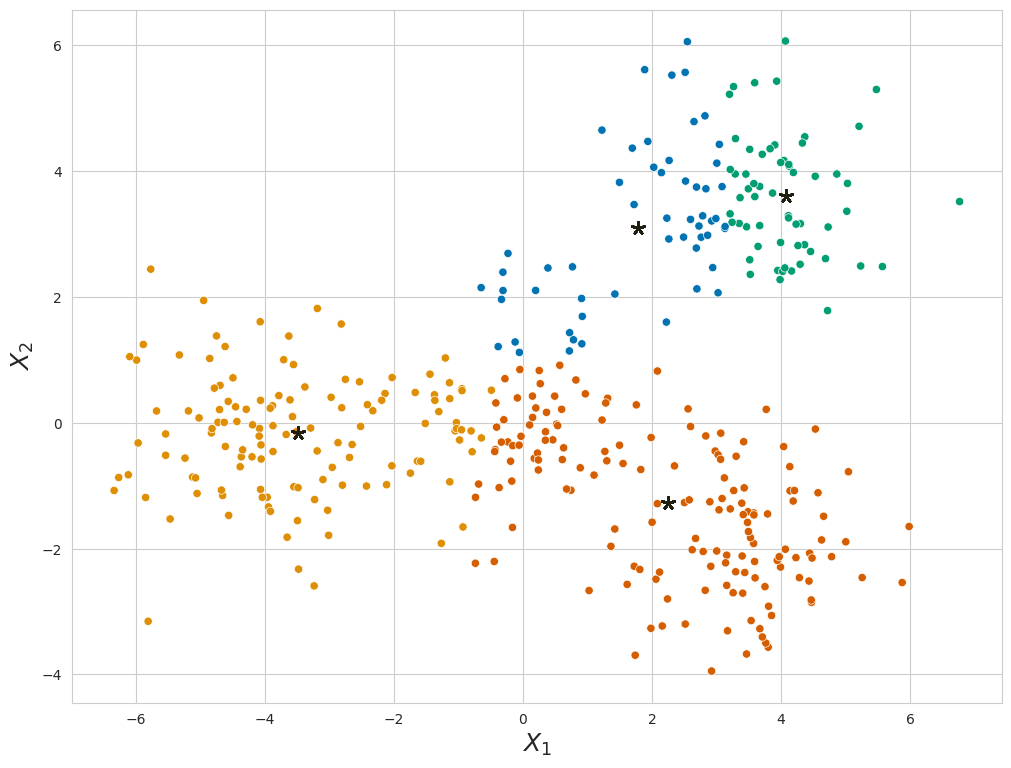

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [26]:
kmeans_predictor = MyKMeans(4, visualize=True, init="sample", max_iter=5)
kmeans_predictor.fit(X)


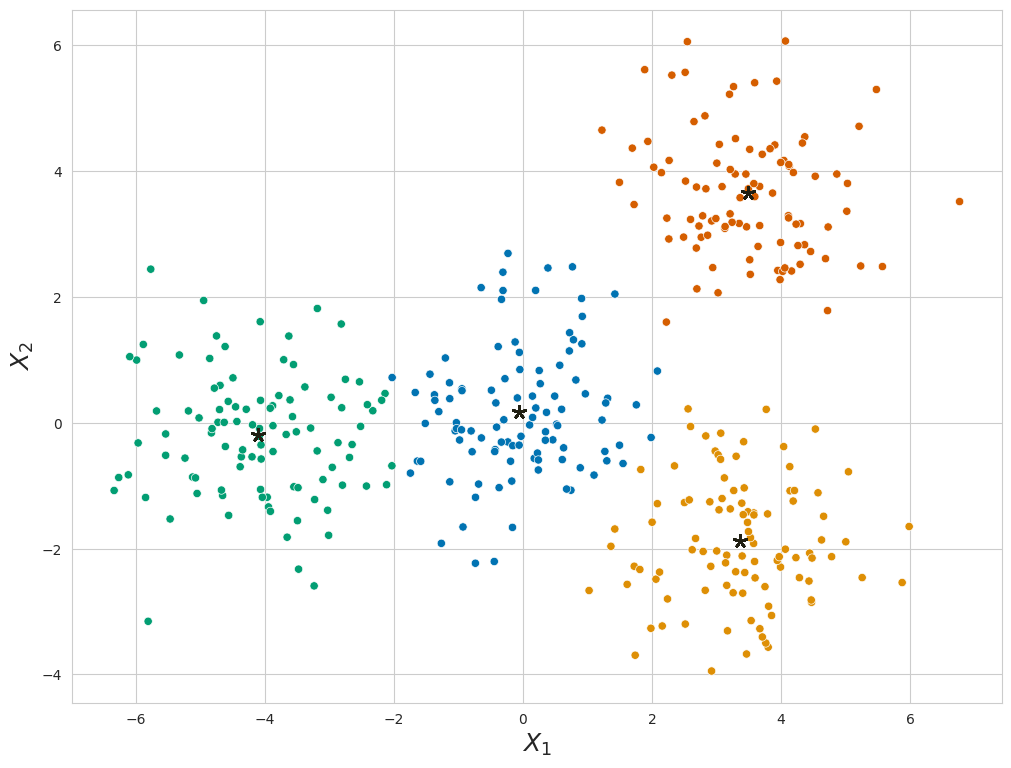

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [9]:
kmeans_predictor = MyKMeans(4, visualize=True, init="random", max_iter=5)
kmeans_predictor.fit(X)


В результате видим, что при выборе центроидов случайно из объектов выборки (способ `sample`) центроиды располагаются далеко от ожидаемых кооридинат, а при генерации центроидов случайно из нормального распределения (способ `random`) даже при небольшом количестве итераций удается добиться сходимости.

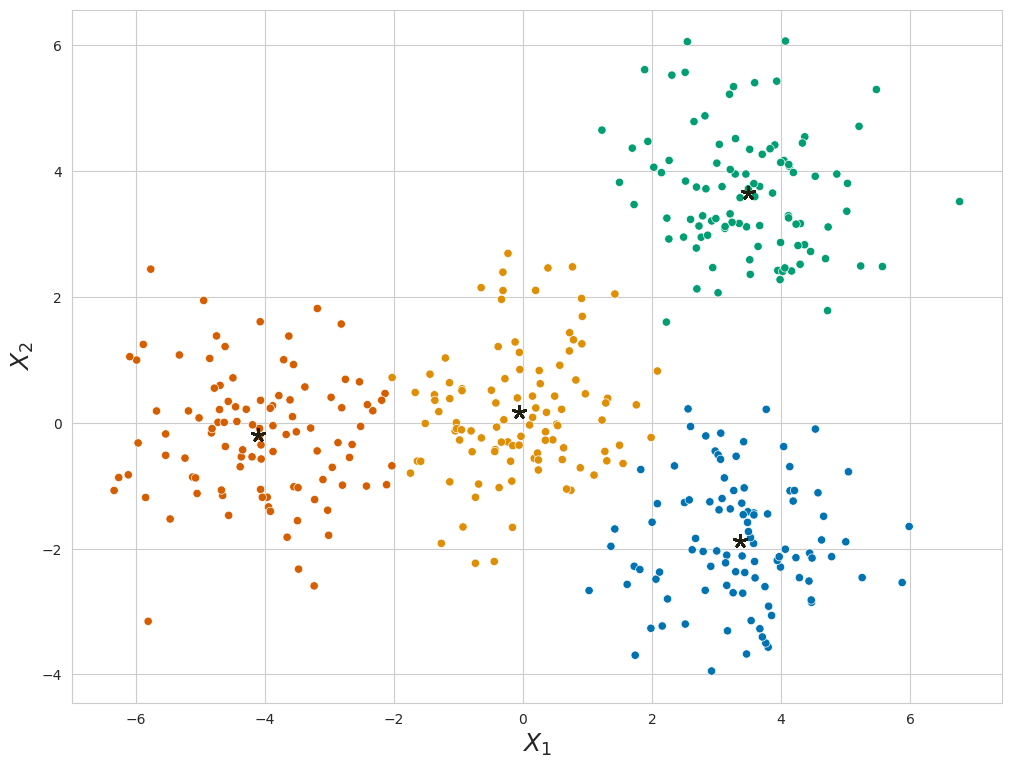

In [10]:
# Теперь предскажем cluster labels при большом количестве итераций
kmeans_predictor = MyKMeans(4, visualize=False, init="random", max_iter=300)
kmeans_predictor.fit(X)
predicted_labeles = kmeans_predictor.predict(X)
visualize_clusters(X, predicted_labeles)

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [11]:
data = load_digits()
X, y = data.data, data.target

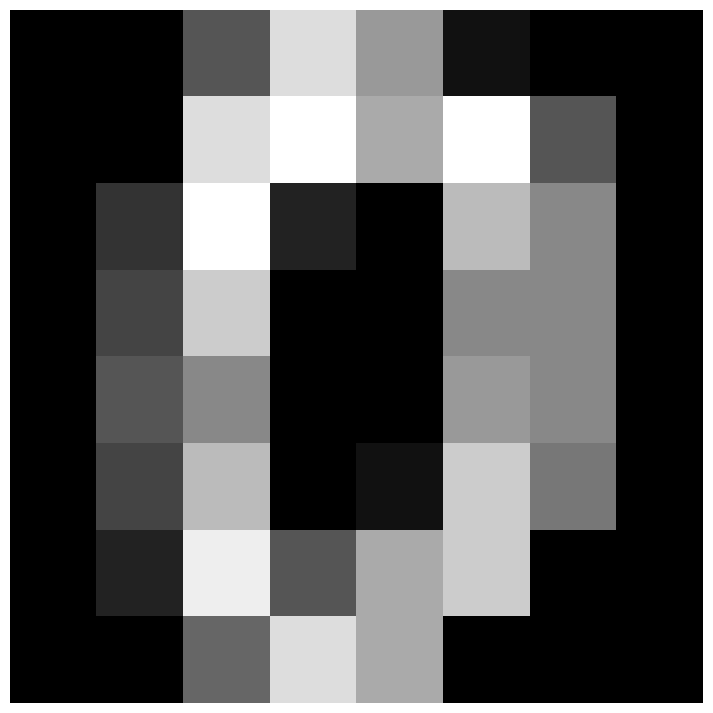

In [12]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

In [68]:
def algorithm_selection(X, distances, algorithms, metrics, labels_true = None, n_clusters= 10):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithms: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """
    # Создадим шаблон датафрейма с незаполненными значениями метрик качества
    data = []
    for distance in distances:
        for algorithm in algorithms:
            data.append({'distance': distance, 'linkage': algorithm})
    compare_dataframe = pd.DataFrame(data)
    for metric in metrics:
        compare_dataframe[metric] = None

    # Удалим строки, где параметр linkage равен 'ward' и метрика расстояния не Евклидова
    compare_dataframe = compare_dataframe.drop(compare_dataframe.query('linkage == "ward" & distance != "euclidean"').index).reset_index(drop=True)
    
    # Предскажем метки классов при разных параметрах и заполним датафрейм значениями метрик качества
    for i in range(len(compare_dataframe)):
        distance = compare_dataframe["distance"][i]
        linkage = compare_dataframe["linkage"][i]
        labels_pred = AgglomerativeClustering(n_clusters = n_clusters, metric = distance, linkage = linkage).fit_predict(X)
        for metric in metrics:
            match metric:
                case "homogeneity":
                    compare_dataframe["homogeneity"][i] = homogeneity_completeness_v_measure(labels_true, labels_pred)[0]
                case "completeness":
                    compare_dataframe["completeness"][i] = homogeneity_completeness_v_measure(labels_true, labels_pred)[1]
                case "v-measure":
                    compare_dataframe["v-measure"][i] = homogeneity_completeness_v_measure(labels_true, labels_pred)[2]
                case "silhouette":
                    compare_dataframe["silhouette"][i] = silhouette_score(X, labels_pred)
    return compare_dataframe

In [14]:
distances = ["euclidean", "manhattan", "cosine"]
algorithms = ['ward', 'complete', 'average', 'single']
metrics = ['homogeneity', 'completeness', 'v-measure', 'silhouette']

In [15]:
df = algorithm_selection(X, distances, algorithms, metrics, labels_true = y)
df.sort_values("homogeneity", ascending=False)

distance   linkage homogeneity completeness v-measure silhouette
0  euclidean      ward    0.857513     0.879096   0.86817   0.178497
2  euclidean   average    0.655393     0.782342  0.713263   0.146625
8     cosine   average    0.648268     0.808762  0.719676   0.129526
4  manhattan  complete    0.646372     0.686109  0.665648   0.140183
1  euclidean  complete    0.590549     0.637772  0.613253   0.119271
5  manhattan   average    0.566751     0.778942  0.656117   0.089217
7     cosine  complete    0.528727     0.577415  0.551999   0.088021
6  manhattan    single    0.005102     0.276237  0.010019  -0.166627
3  euclidean    single    0.005056     0.273755  0.009929  -0.133621
9     cosine    single     0.00505     0.273389  0.009916   -0.15825

**Вывод:** на предложенных данных наилучшие показатели качества имеет иерархическая кластеризация с linkage функцией '*ward*' и использованием *Евклидового расстояния*.

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [136]:
fc_data = pd.read_csv("../data/flow_c_data.csv", index_col=0)
fc_data.head(10)

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0  0.722199  0.154232  0.494449  0.512853  4.057328  1.019255  4.007273   
1  0.751073  0.114618  4.671924  0.822042  4.933149  0.159388 -0.216407   
2  1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   
3  0.553310  0.119929  0.345968  3.332310  5.260935  1.481229  0.264846   
4  0.774884  0.076984  4.984963  0.885501  4.562367  0.217117  0.086279   
5  0.711371  0.150064  4.733174  1.840015  4.940239  1.341667 -0.864946   
6  0.809136  0.096800  5.697170  1.402269  4.980079  0.105720  0.133612   
7  0.950832  0.125347  4.483281  0.733446  4.600168  0.417541  0.501623   
8  0.840095  0.097210  3.998878 -1.463435  4.644376  0.320416  0.014630   
9  0.835191  0.109194  4.135429  0.292766  5.254400 -0.185462 -0.372660   

       CD19     CD11c  
0 -1.406912  0.384406  
1  6.034845  0.577039  
2 -0.318668 -0.493832  
3  0.694883  3.416960  
4  5.563345  0.471591  
5  4.896800 -0.005327  
6  5.767286  0.631591  
7  5.463607 -2.231865  
8  5.122806 -1.784429  
9  5.664273  1.363348

##### YOUR TURN TO CODE:

In [41]:
# Воспользуемся собственной функцией для EDA из домашки по питону из прошлого семестра
from my_awesome_eda import run_eda
run_eda(fc_data)

Hello!
Here is the results of EDA:

Rows: 10000
Columns: 9

Numeric variables
             sum    min    max   std  median  0.25Q  0.75Q
FSC-A    9624.58   0.14  42.95  0.50    0.91   0.80   1.05
SSC-A    1654.15   0.02  15.46  0.19    0.13   0.11   0.16
HLA-DR  17915.79  -7.63  12.95  2.03    1.19   0.28   3.70
CD3     32803.91  -2.52  13.84  2.11    4.37   1.40   4.84
CD45    51698.45  -8.33  13.71  0.52    5.23   4.92   5.48
CD14    10971.82  -8.83   6.29  1.38    0.67   0.39   1.07
CD56     4122.23 -12.36   6.46  1.18    0.05  -0.20   0.38
CD19    12196.83  -9.64   7.21  2.29    0.24  -0.15   0.91
CD11c    5698.98 -11.09   6.84  1.50    0.27  -0.50   1.22

Total NA: 0
Rows with NA: 0
Number of NA's by columns:
FSC-A     0
SSC-A     0
HLA-DR    0
CD3       0
CD45      0
CD14      0
CD56      0
CD19      0
CD11c     0

Duplicates: 0



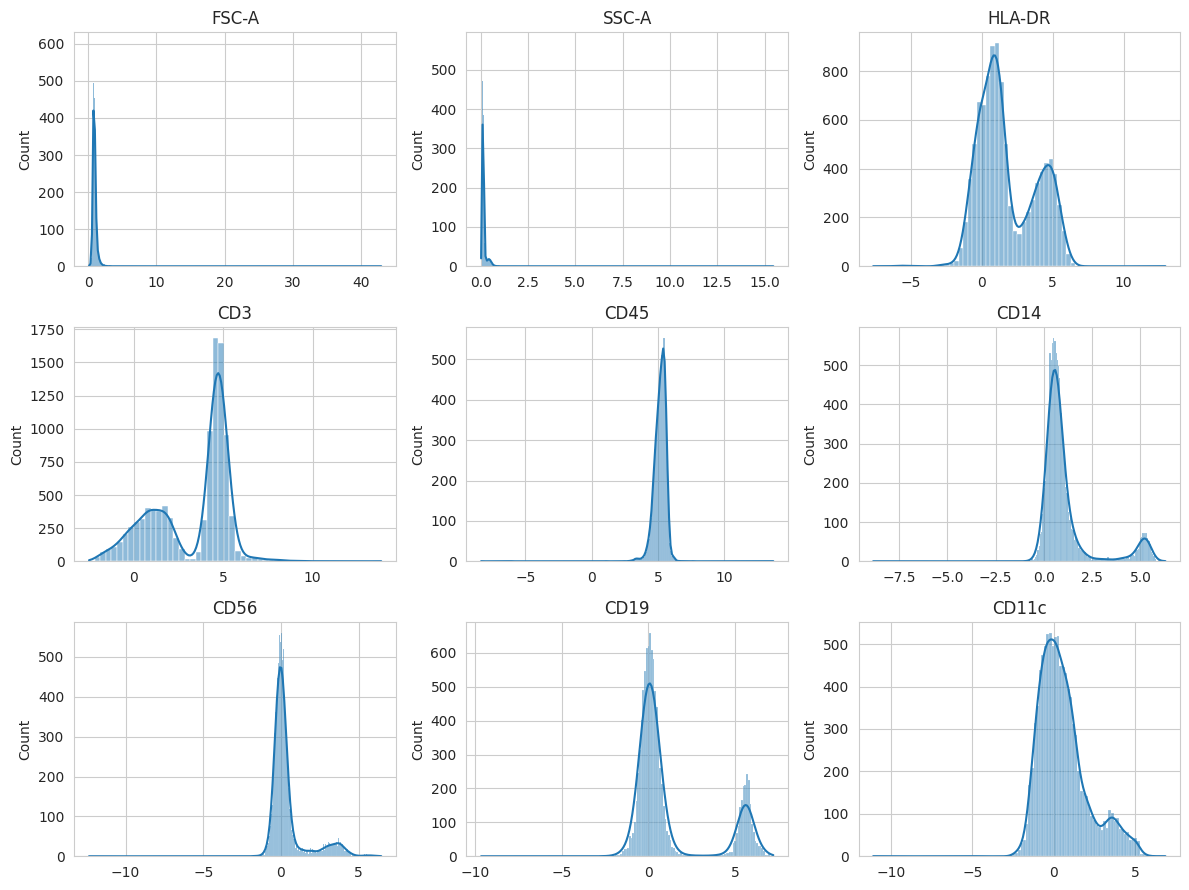

In [42]:
# Оценим распредление переменных-предикторов
for i, col in enumerate(fc_data.columns):
    plt.subplot(3, 3, i + 1)
    ax = sns.histplot(fc_data[col], kde = True)
    ax.set(xlabel=None)
    plt.title(col)
plt.tight_layout()
plt.show()

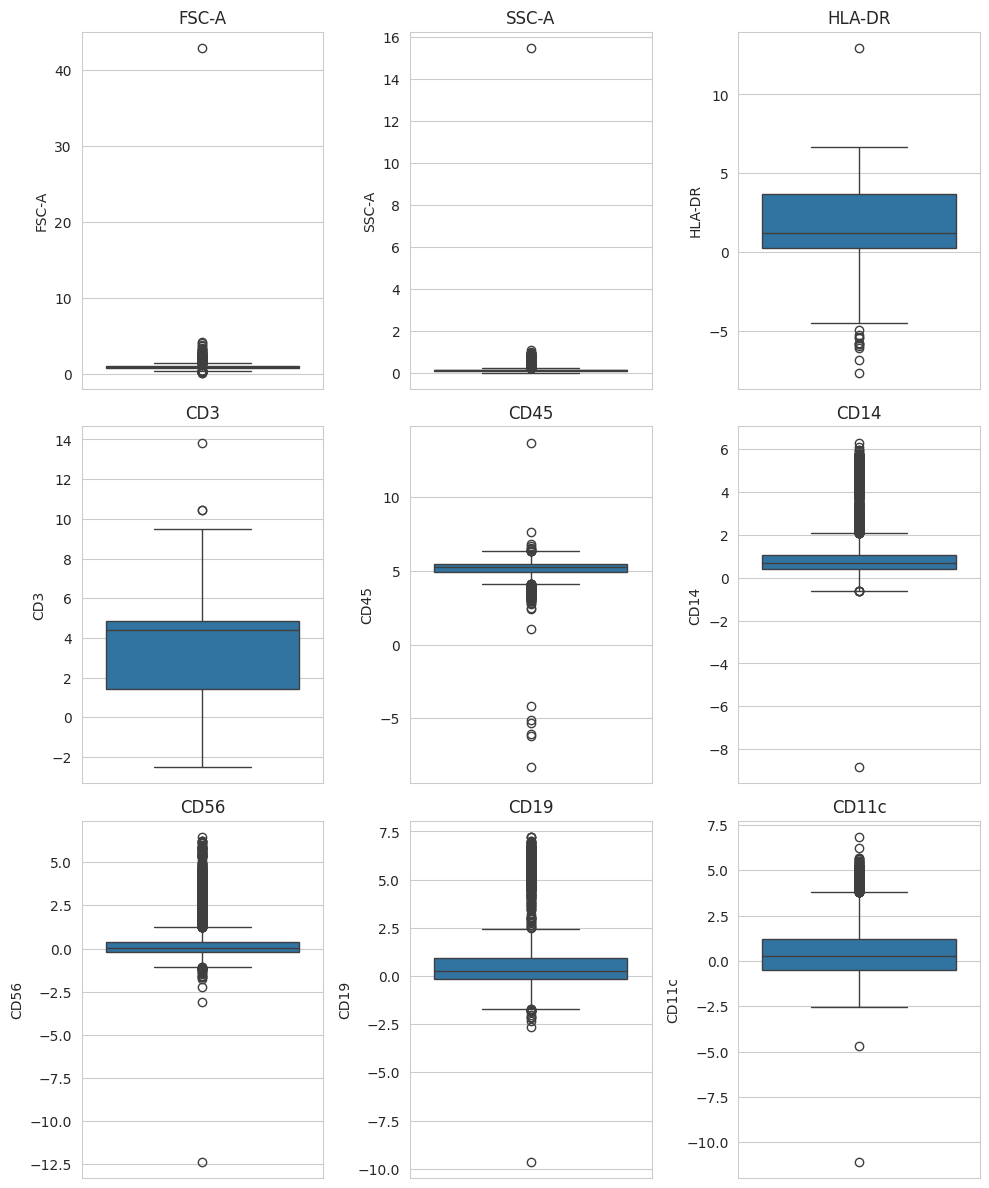

In [117]:
# Проверим на наличие выбросов
plt.figure(figsize=(10, 12))
for i, col in enumerate(fc_data.columns):
    plt.subplot(3, 3, i + 1)
    ax = sns.boxplot(fc_data[col])
    ax.set(xlabel=None)
    plt.title(col)
plt.tight_layout()
plt.show()

В переменных **FSC-A** и **SSC-A** есть очевидные выбросы, удалим их. 

In [147]:
fc_data = fc_data[(fc_data["FSC-A"]< 40) & (fc_data["SSC-A"] < 14)]

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [59]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

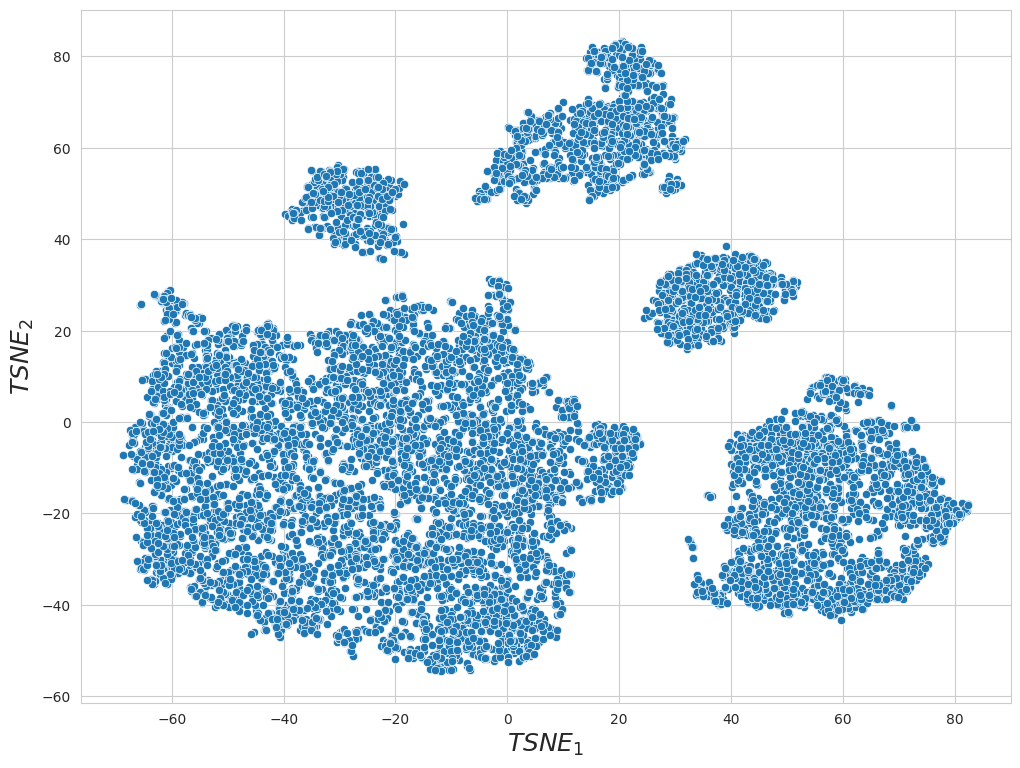

In [148]:
tsne_res = plot_tsne(fc_data)

Предположим, что количество кластеров (и типов клеток, соответственно) равно 4.

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

In [168]:
X = fc_data.to_numpy()
X.shape

(9999, 9)

In [175]:
# Иерархическая кластеризация
df = algorithm_selection(X, distances, algorithms, metrics = ["silhouette"], n_clusters = 4)
df.sort_values("silhouette", ascending=False)

distance   linkage silhouette
3  euclidean    single   0.635343
6  manhattan    single   0.635343
0  euclidean      ward   0.612248
8     cosine   average   0.610367
7     cosine  complete   0.519763
4  manhattan  complete   0.475199
1  euclidean  complete   0.470696
2  euclidean   average   0.449268
5  manhattan   average    0.40377
9     cosine    single    0.19802

In [190]:
# Предскажем метки классов с помощью Иерархической кластеризации при наилучших параметрах*
labels_pred_HC = AgglomerativeClustering(n_clusters = 4, metric = "euclidean", linkage = "ward").fit_predict(X)

*Несмотря на то, что Silhouette Score наибольший при использовании 'single' linkage-функции, после визуализации на t-SNE был выбран linkage 'ward'.

In [172]:
# KMeans кластеризация
labels_pred_KMeans = KMeans(n_clusters=4).fit_predict(X)
print(f"Silhouette score: {silhouette_score(X, labels_pred_KMeans)}")

Silhouette score: 0.61110038397796


Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

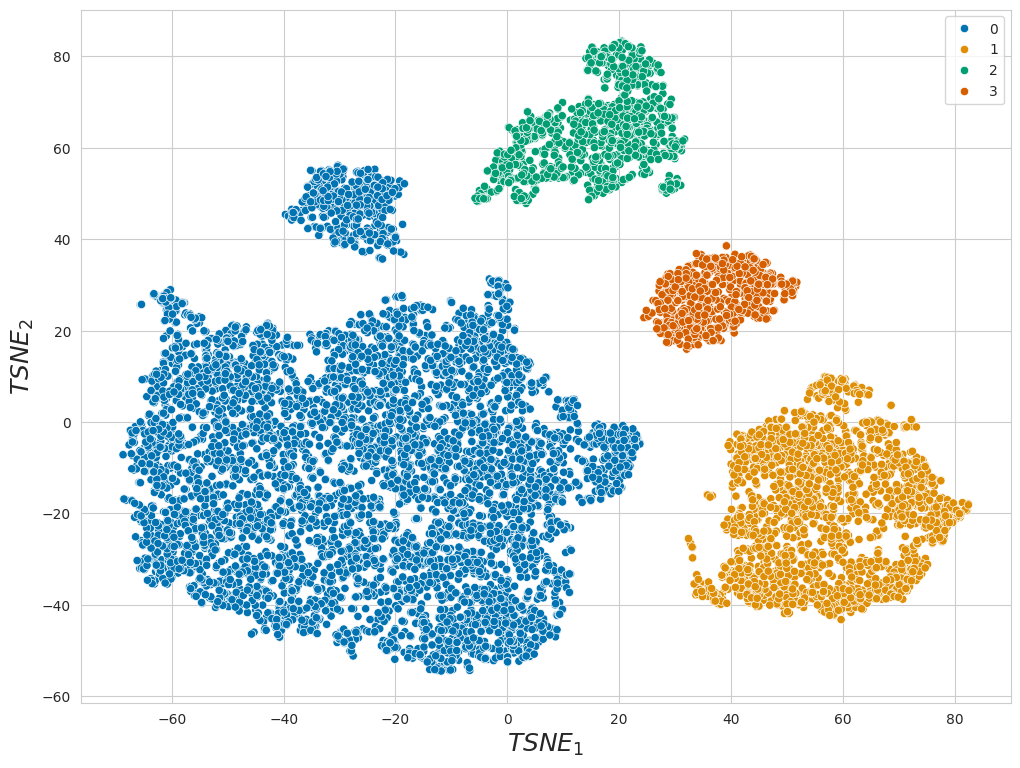

In [193]:
# Результаты методом иерархической кластеризации
sns.scatterplot(x=tsne_res[:, 0],
                y=tsne_res[:, 1],
                hue=labels_pred_HC, palette="colorblind")
plt.xlabel("$TSNE_1$", fontsize=18)
plt.ylabel("$TSNE_2$", fontsize=18)
plt.show()

Видим, что **отдельные группы точек покрашены в один цвет**!

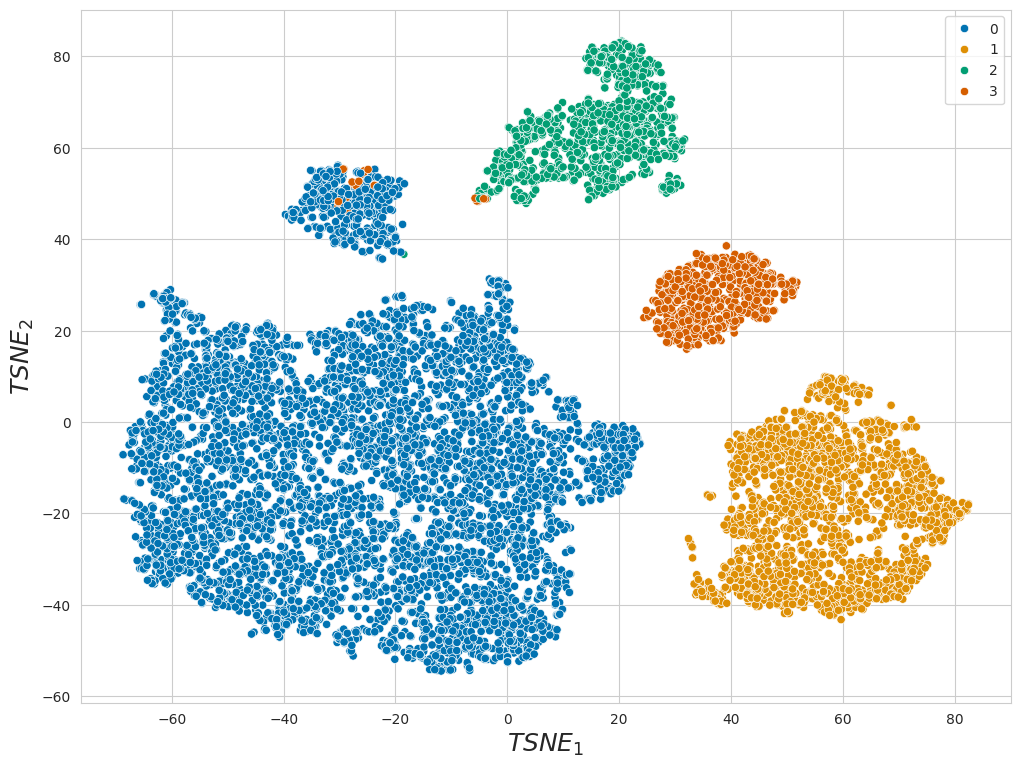

In [194]:
# Результаты кластеризации методом KMeans
sns.scatterplot(x=tsne_res[:, 0],
                y=tsne_res[:, 1],
                hue=labels_pred_KMeans, palette="colorblind")
plt.xlabel("$TSNE_1$", fontsize=18)
plt.ylabel("$TSNE_2$", fontsize=18)
plt.show()

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

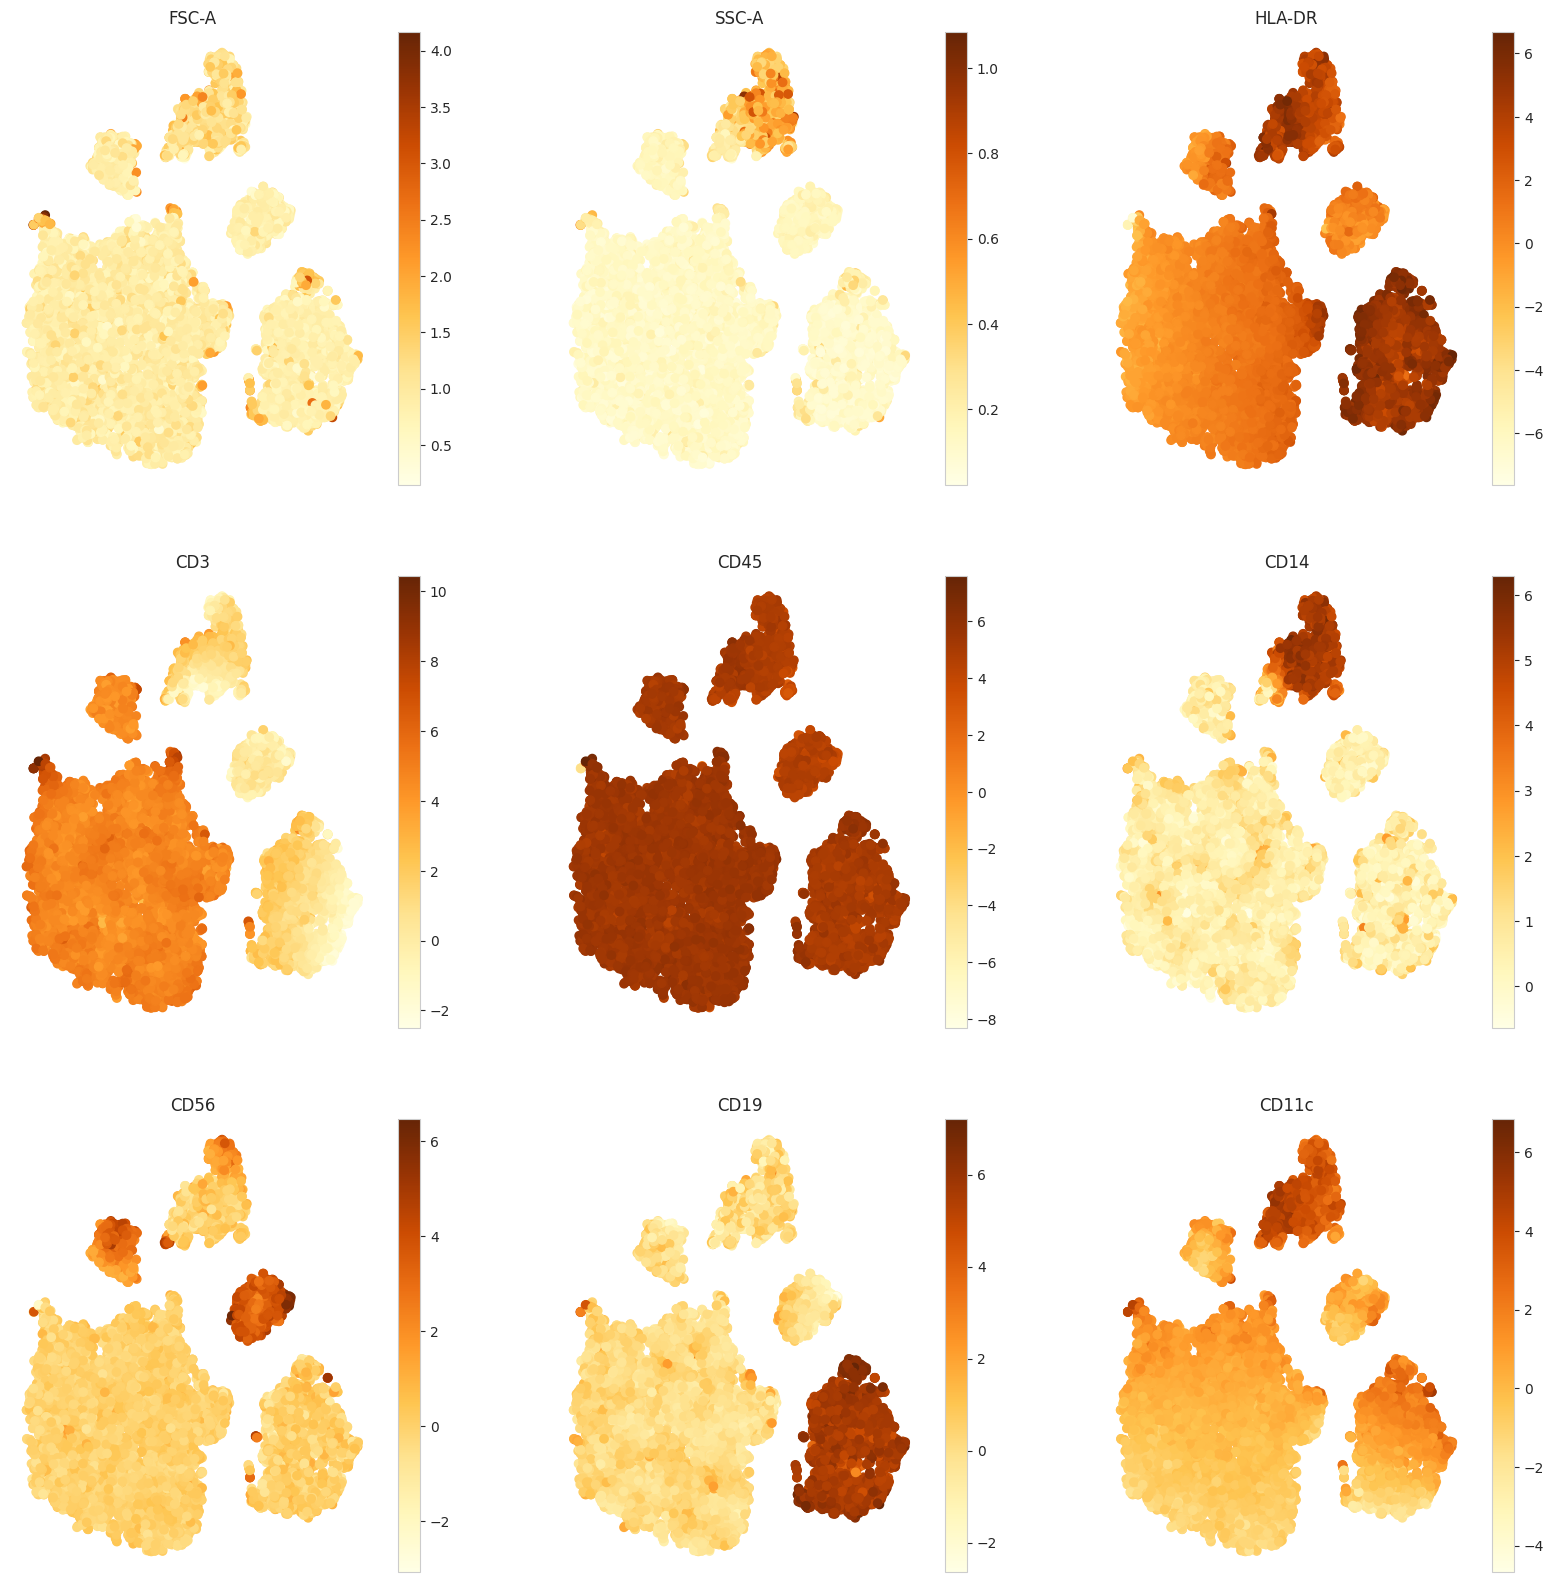

In [162]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [195]:
cell_type_cluster_map = {0: "T_cells", # CD3+, CD56+
                         1: "B_cells", # CD19+
                         2: "Monocytes",  # CD14+, HLA-DR+
                         3: "Other cells"} 

In [196]:
labeled_fc_data = fc_data.assign(Population=labels_pred_HC)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

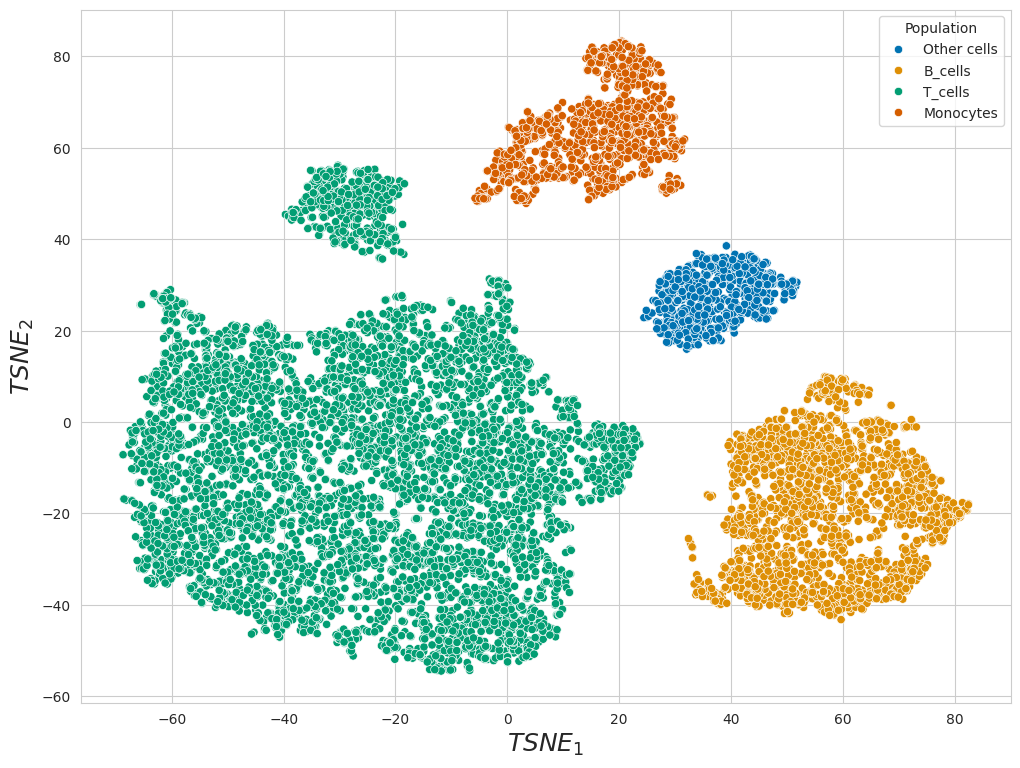

In [227]:
# Размещение клеток разных типов на t-SNE
sns.scatterplot(x=tsne_res[:, 0],
                y=tsne_res[:, 1],
                hue=labeled_fc_data["Population"], palette="colorblind")
plt.xlabel("$TSNE_1$", fontsize=18)
plt.ylabel("$TSNE_2$", fontsize=18)
plt.show()

Посчитайте, как распределены типы клеток:

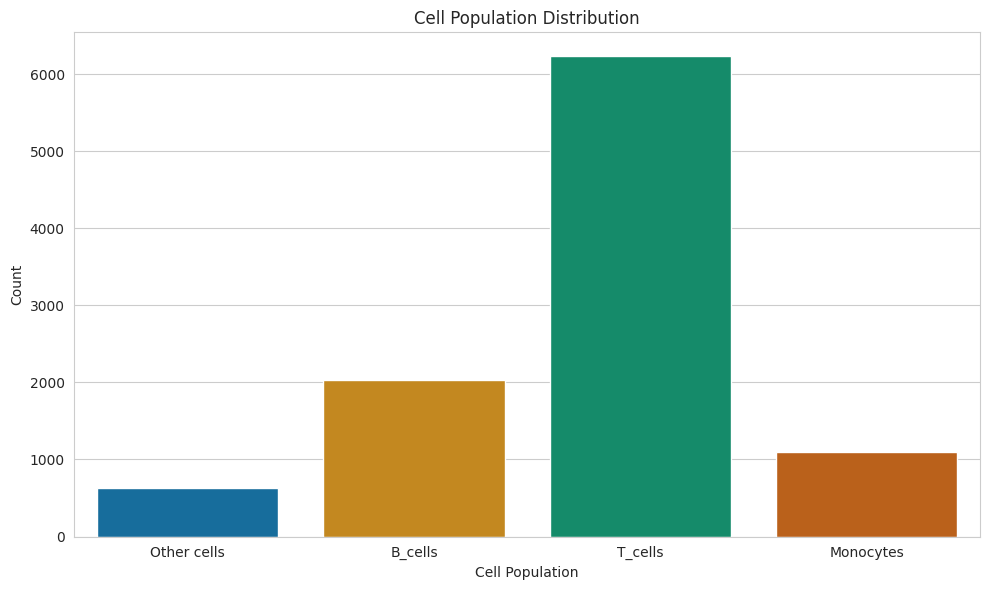

In [230]:
plt.figure(figsize=(10, 6))
sns.countplot(data=labeled_fc_data, x='Population', palette="colorblind")
plt.xlabel('Cell Population')
plt.ylabel('Count')
plt.title('Cell Population Distribution')
plt.tight_layout()  
plt.show()


Классы, отвечающие за разные клеточные типы, не сбалансированы по размеру.

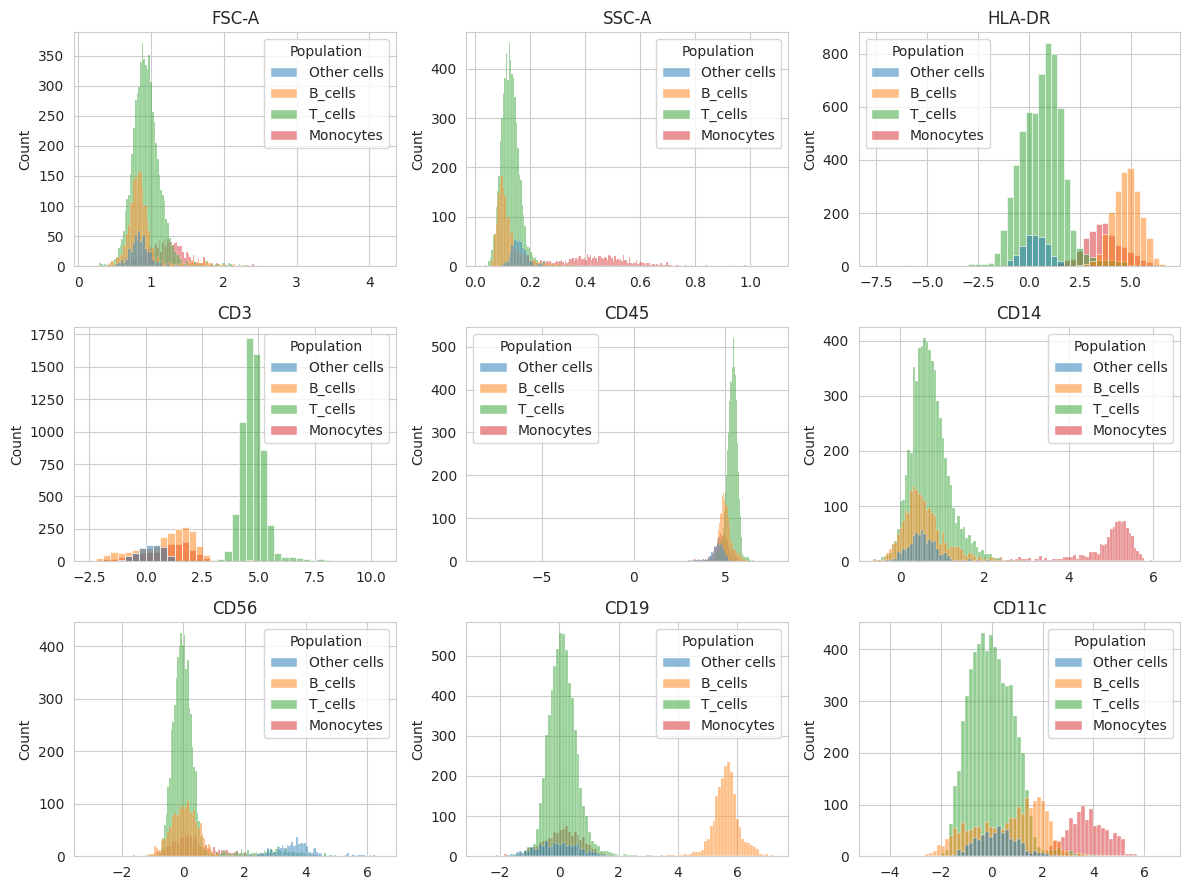

In [220]:
# Посмотрим на распредление разных типов клеток по поверхностным маркерам
for i, col in enumerate(fc_data.columns):
    plt.subplot(3, 3, i + 1)
    ax = sns.histplot(data = labeled_fc_data, x = col, hue="Population")
    ax.set(xlabel=None)
    plt.title(col)
plt.tight_layout()
plt.show()

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [229]:
labeled_fc_data.to_csv('../data/labeled_fc_data.csv', index=False)  

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Весной - любые пригородные районы Питера. Например, Ломоносов прошлой весной, ближе к маю:

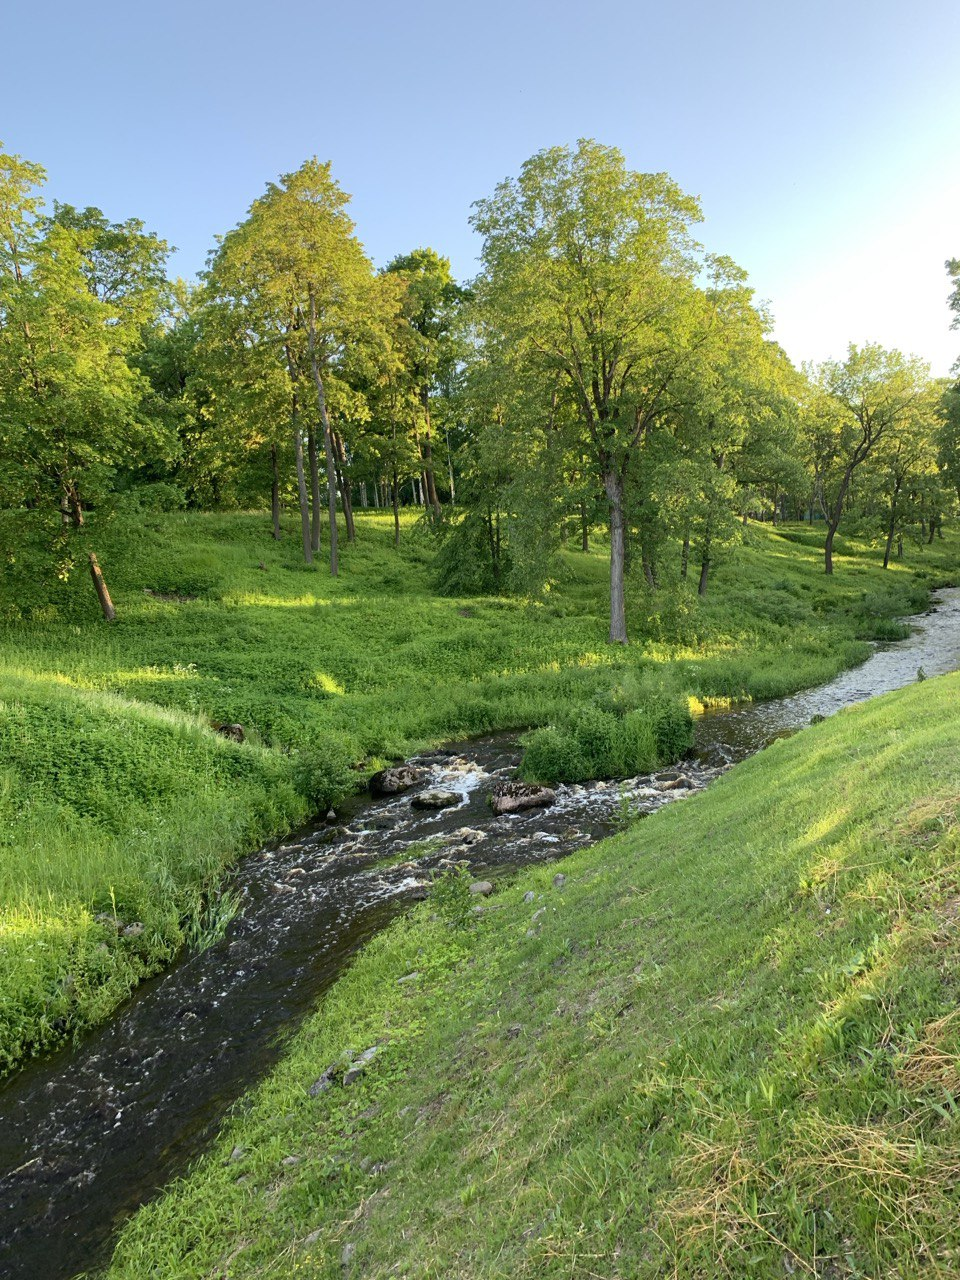

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Пока самая приятная из всех домашек, возможно действительно со временем лучше понимаешь как все устроено и становится проще ориентироваться. Особенно было полезно и интересно каждый свой шаг подтверждать визуализацией данных.